# Catchment Area Delineation

by : Chanika Janlueng

In [2]:
# pip install whitebox rasterio geopandas

In [22]:
import whitebox
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt

In [24]:
dem = rasterio.open(r"C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas\SRTM_DEM_48N.tif")
pour_points = gpd.read_file(r"C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas\Snappour_points.shp")

In [ ]:
# compare the CRS of both a DEM raster file and a pour points shapefile
print("DEM CRS:", dem.crs)
print("Pour points CRS:", pour_points.crs)

DEM CRS: EPSG:32648
Pour points CRS: EPSG:32648


In [48]:
# Initialize WhiteboxTools
wbt = whitebox.WhiteboxTools()
wbt.verbose = True
wbt.work_dir = r"C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas"  # Working path

In [59]:
# Input files
dem = r"C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas\SRTM_DEM_48N.tif"
pour_points = r"C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas\Snappour_points.shp"

In [60]:
# Step 1: Fill depressions in DEM
wbt.fill_depressions(dem, "filled_dem.tif")

# Step 2: Compute D8 flow direction
wbt.d8_pointer("filled_dem.tif", "flow_dir.tif")

# Step 3: Calculate flow accumulation
wbt.d8_flow_accumulation("flow_dir.tif", "flow_acc.tif", out_type="cells")

# # Step 4: Extract streams (for checking pour points Or Map production)
# wbt.extract_streams("flow_acc.tif", "streams.tif", threshold=20)

# Step 5: Snap pour points to high-flow cells
wbt.snap_pour_points(pour_points, "flow_acc.tif", "snapped_pp.shp", snap_dist=8)

# Step 6: Delineate watersheds
wbt.watershed("flow_dir.tif", "snapped_pp.shp", "watersheds.tif")

# Step 7: Convert watershed raster to polygons
wbt.raster_to_vector_polygons("watersheds.tif", "watersheds_vector.shp")


.\whitebox_tools.exe --run="FillDepressions" --wd="C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas" --dem='C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas\SRTM_DEM_48N.tif' --output='filled_dem.tif' --fix_flats -v --compress_rasters=False

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Finding pit cells: 6%
Finding pit cells: 12%
Finding pit cells: 18%
Finding pit cells: 25%
Finding pit cells: 31%
Finding pit cells: 37%
Finding pit cells: 43%
Finding pit cells: 50%
Finding pit cells: 56%
Finding pit cells: 62%
Finding pit cells: 68%
Finding pit cells: 75%
Finding pit cells: 81%
Finding pit cells: 87%
Finding pit cells: 93%
Finding pit cells: 100%
Filling depressions: 0%
Filling depressions: 1%
Filling depressions: 2%
Filling depressions: 3%
Filling depressions: 4%
Filling depressions: 5%
Filling depressions: 6%
Filling depress

0

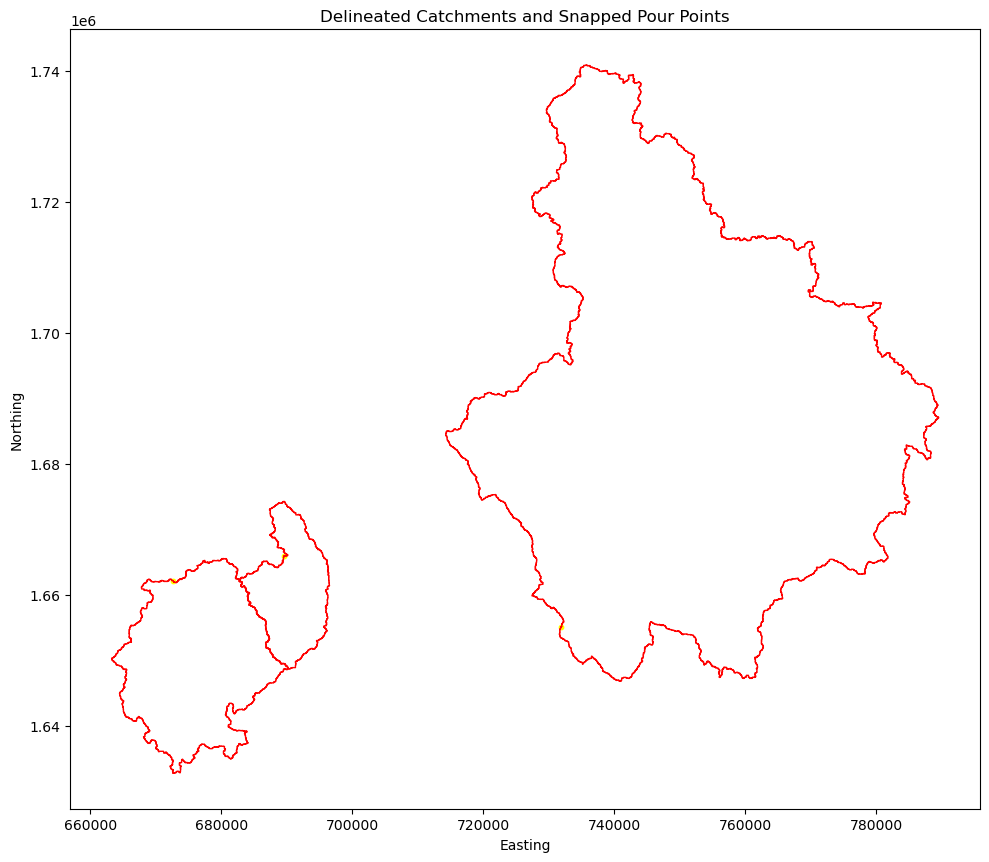

In [61]:

# Load snapped pour points
snapped_pp = gpd.read_file("snapped_pp.shp")

# Load watershed polygons
watersheds = gpd.read_file("watersheds_vector.shp")

# Plot everything
fig, ax = plt.subplots(figsize=(10, 10))

# Plot watershed boundaries
watersheds.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

# Plot snapped pour points
snapped_pp.plot(ax=ax, color='yellow', markersize=10)

# Labels and styling
plt.title("Delineated Catchments and Snapped Pour Points")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.tight_layout()
plt.show()


---
# Area Calculation and Splitting Catchments

In [ ]:
# import os
# import geopandas as gpd

In [62]:
# Load watershed vector
watersheds = gpd.read_file("watersheds_vector.shp")

In [63]:
watersheds.head()

,FID,VALUE,geometry
0,1,1.0,"POLYGON ((735740.325 1740869.54, 735799.402 17..."
1,2,2.0,"POLYGON ((689512.311 1674217.38, 689630.465 16..."
2,3,3.0,"POLYGON ((680266.708 1665512.807, 680296.246 1..."


In [64]:

# 1. Calculate area in km² 
watersheds['area_km2'] = watersheds.geometry.area / 10**6  # Area in square kilometers

In [65]:
watersheds.head()

,FID,VALUE,geometry,area_km2
0,1,1.0,"POLYGON ((735740.325 1740869.54, 735799.402 17...",3703.535704
1,2,2.0,"POLYGON ((689512.311 1674217.38, 689630.465 16...",193.722677
2,3,3.0,"POLYGON ((680266.708 1665512.807, 680296.246 1...",511.657991


In [66]:
# 2. Create a folder for each catchment and save them individually
output_dir = r"C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas\Split_Catchments"  # <-- output folder

In [67]:

# 3. Loop through each catchment and save it to a separate shapefile
for idx, row in watersheds.iterrows():
    catchment_id = row['FID'] 
    catchment_geom = row['geometry']

    # Define the output path
    output_shapefile = os.path.join(output_dir, f"catchment_{catchment_id}.shp")

    # Filter the watershed to this single catchment
    catchment = watersheds[watersheds['FID'] == catchment_id]

    # Save the catchment as a new shapefile
    catchment.to_file(output_shapefile)

    # Print confirmation
    print(f"Saved catchment {catchment_id} to {output_shapefile}")

# 4. Optional: Check if areas were added correctly
print(watersheds[['FID', 'area_km2']])

Saved catchment 1 to C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas\Split_Catchments\catchment_1.shp
Saved catchment 2 to C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas\Split_Catchments\catchment_2.shp
Saved catchment 3 to C:\Users\Asus\OneDrive\Desktop\Working\GIS Automate\CatchmentAreas\Split_Catchments\catchment_3.shp
   FID     area_km2
0    1  3703.535704
1    2   193.722677
2    3   511.657991
